# BOARD GAME RECOMMENDER PROJECT

This is an example project for a basic recommender system.
It is based on a kaggle dataset scraped from Board Game Geek (like IMDB but for board games).The dataset contains both games metadata and more than 19M users rating and reviews.

The recommender is based on rating corralation, meaning that the recommendations are based on user behavior rather than the game's attributes, although I added the option to filter the recommendations based on common traits such as game category or complexity. 

So for example, if you like'd Settlers of Catan, the model checks which other games were also highly rated by those who loved Settlers of Catan.

The projects process contains:
1. Import and organization of data
2. EDA (exploratory data analysis)
3. Model creation and output

## Project set up

### Dataset explanation

#### Metadata table
The metadata table we are going to use is the games info table,
which has the following columns:

id - the game id (across all datasets)

primary - game name

**General information columns:**

yearpublished, playingtime
averageweight - how complex is the game (1-5)
min/max players - what is the min/max players this game is suited to

**Tag columns:**

boardgamemechanic, boardgamefamily, boardgamedesigner, boardgamepublisher,
boardgamecategory

**Ranking related columns**

Board Game Rank - aggregated ranking based on BBG's methodology
average - average rating by users
usersrated - how many users rated this game
numcomments - how many comments this game has recieved

#### Reviews table
from this table we only take 3 relevant columns:

id - game id

user - user id

rating - the user's rating of the game (1-10)


### Imports

In [1]:
import random
import numpy as np 
import pandas as pd 
import os
from basic_utils import INPUT_FOLDER, dfCleaner
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
from matplotlib.ticker import PercentFormatter

### Constants

In [2]:
DATA_PATH = os.path.join(INPUT_FOLDER, "boardgamegeek-reviews")
GAME_INFO_COLS = ['id','primary','yearpublished','minplayers','maxplayers',
                  'playingtime','boardgamecategory','boardgamemechanic',
                  'boardgamefamily','boardgamedesigner','boardgamepublisher',
                  'usersrated','average','Board Game Rank','numcomments',
                  'averageweight']
RATING_COLS = ['user','rating','ID']
random.seed(4321)
label_encoder = LabelEncoder()
df_cleaner = dfCleaner()
RANDOM_SAMPLE_SIZE = 0.2
TOP_GAMES = 1000
CORRELATION_THRESHOLD = 0.3
OUTLIERS_Z_SCORE = 3
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

In [3]:
# if you wish to filter the recommended games by a certain category
# or game attribute, you can modifiy it here.
# similarly, you can choose which game you would want to base
# your recommendations on.
CATEGORY_FILTER = {
    "boardgamecategory": None,
    "boardgamepublisher": None,
    "boardgamemechanic": None
}
NUMERIC_FILTER = {
    "playingtime": None,
    "average": {"measure": "above", "threshold": 7},
    "averageweight": None
}
EXAMPLE_GAME = 183840

## Data cleaning

In [4]:
games_info = pd.read_csv(os.path.join(DATA_PATH, "games_detailed_info.csv"), 
                         usecols=GAME_INFO_COLS)
games_info.head(2)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,primary,yearpublished,minplayers,maxplayers,playingtime,boardgamecategory,boardgamemechanic,boardgamefamily,boardgamedesigner,boardgamepublisher,usersrated,average,Board Game Rank,numcomments,averageweight
0,30549,Pandemic,2008,2,4,45,['Medical'],"['Action Points', 'Cooperative Game', 'Hand Ma...","['Components: Map (Global Scale)', 'Components...",['Matt Leacock'],"['Z-Man Games', 'Albi', 'Asmodee', 'Asmodee It...",109006,7.58896,106,17305,2.4063
1,822,Carcassonne,2000,2,5,45,"['City Building', 'Medieval', 'Territory Build...","['Area Majority / Influence', 'Map Addition', ...","['Cities: Carcassonne (France)', 'Components: ...",['Klaus-Jürgen Wrede'],"['Hans im Glück', '999 Games', 'Albi', 'Bard C...",108776,7.41837,191,19263,1.9057


In [5]:
# this dataset contains information about 20K games
# we can see that some columns have outlier results such as playing time of 1000 hours,
# 0 min players, or 999 max players.
# however, the ranking columns seems fine.
games_info.describe()

,id,yearpublished,minplayers,maxplayers,playingtime,usersrated,average,numcomments,averageweight
count,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000
mean,118133.093847,1986.094910,2.007027,5.709491,90.509177,875.000693,6.417127,213.221811,1.978830
std,105310.419253,210.042496,0.688957,15.102385,534.826511,3697.681390,0.929178,674.130830,0.848984
min,1.000000,-3500.000000,0.000000,0.000000,0.000000,29.000000,1.041330,1.000000,0.000000
25%,12280.500000,2001.000000,2.000000,4.000000,25.000000,57.000000,5.832710,24.000000,1.333300
50%,105187.000000,2011.000000,2.000000,4.000000,45.000000,124.000000,6.446360,51.000000,1.952400
75%,207013.000000,2017.000000,2.000000,6.000000,90.000000,397.000000,7.039515,138.000000,2.520000
max,350992.000000,2023.000000,10.000000,999.000000,60000.000000,109006.000000,9.568290,19402.000000,5.000000


for the outliers, we would replace all results that have a z-score of 3 or higher, meaning the results are less than 0.1% of the total distribution assuming a normal distribution.

some columns require a more specific cleaning, such as the "minplayers"
that shouldn't contain 0, or the board game rank that is categorized as object since it has string values of "not ranked". we replace those with NAN instead.

post cleaning, we can see that data contains only null for the non-numeric sections such as designer, mechanic, etc...

In [6]:
df_cleaner.outlier_replace_with_nan(df_to_clean=games_info, columns_to_clean=['playingtime','maxplayers'],z_score=OUTLIERS_Z_SCORE)
games_info.loc[games_info['minplayers']==0, 'minplayers'] = np.NaN
games_info['Board Game Rank'] = pd.to_numeric(games_info['Board Game Rank'], errors='coerce')

# this code optimizes column types to improve memory usage and speed of calculations
# this would reduce memory in 35%
df_cleaner.column_optimizer(df_to_optimize=games_info)

games_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21631 entries, 0 to 21630
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  21631 non-null  int32  
 1   primary             21631 non-null  object 
 2   yearpublished       21631 non-null  int16  
 3   minplayers          21587 non-null  float32
 4   maxplayers          21442 non-null  float32
 5   playingtime         21565 non-null  float32
 6   boardgamecategory   21348 non-null  object 
 7   boardgamemechanic   20041 non-null  object 
 8   boardgamefamily     17870 non-null  object 
 9   boardgamedesigner   21035 non-null  object 
 10  boardgamepublisher  21630 non-null  object 
 11  usersrated          21631 non-null  int32  
 12  average             21631 non-null  float32
 13  Board Game Rank     21626 non-null  float32
 14  numcomments         21631 non-null  int16  
 15  averageweight       21631 non-null  float32
dtypes: f

In [7]:
# for the sake of speed, we read a random 20% of the rows, which are ~4M rows
reviews = pd.read_csv(os.path.join(DATA_PATH, "bgg-19m-reviews.csv"), 
                      usecols=RATING_COLS, skiprows=lambda x: x > 0 and random.random() >=RANDOM_SAMPLE_SIZE)
df_cleaner.column_name_cleaner(df_to_clean=reviews)
reviews.head(2)

,user,rating,id
0,avlawn,10.0,30549
1,Mike Mayer,10.0,30549


the rating column seems to make sense, all results fall between 1-10 with a reasonable distribution

In [8]:
reviews.describe()

,rating,id
count,3.791455e+06,3.791455e+06
mean,7.082014e+00,1.101161e+05
std,1.595863e+00,9.309324e+04
min,1.000000e-30,1.000000e+00
25%,6.000000e+00,1.598700e+04
50%,7.000000e+00,1.075290e+05
75%,8.000000e+00,1.813040e+05
max,1.000000e+01,3.509920e+05


there is no reason to keep user names as string, so we convert them to unique IDS.
Additionaly, the dataset contain reviews for games that don't appear in our games_info table, therefore we remove them

In [9]:
reviews['user'] = label_encoder.fit_transform(reviews['user'])

# similarly, we try to optimize memory usage of this dataframe
df_cleaner.column_optimizer(df_to_optimize=reviews)

reviews = reviews[reviews['id'].isin(games_info['id'])]

## EDA

Since our model uses only the ratings column, our EDA would focus on that.
When we look at the users ratings, we can see that most people rate whole digits, i.e 5,6,7 and less so on fractions such as 7.5, 8.5 etc...

Additionally, we see that the rating is normally distributed around 7, which makes sense since it means that low rated games aren't popular, and highly rated games are rare.

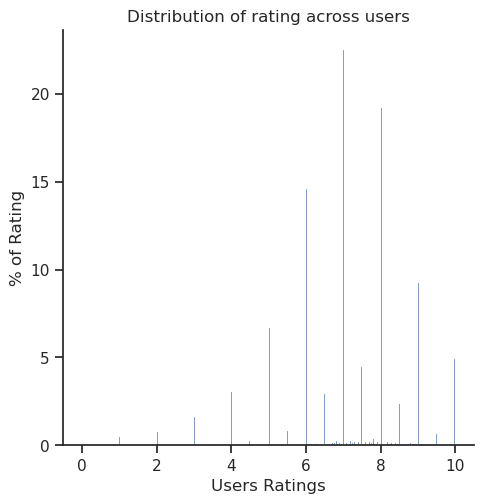

In [10]:
ax = sns.displot(data=reviews, x='rating', stat='percent', fill="blue")
ax.set(xlabel="Users Ratings",
       ylabel='% of Rating',
       title='Distribution of rating across users')

In [11]:
rated_games = reviews.groupby("id").agg({"rating": "mean", "user": "count"}).reset_index()
rated_games.sort_values("rating").head()

,id,rating,user
17896,240624,1.000000,19
12368,144110,1.000000,17
7608,28257,1.142857,7
19675,276022,1.145833,48
1150,1546,1.400000,5


In [12]:
# we can see that it is highly skewed, since most of the games have very
# low amount of reviews, while the max is very high
rated_games.describe()

,id,rating,user
count,21623.000000,21623.000000,21623.000000
mean,118162.587060,6.416710,175.251954
std,105311.991688,0.998625,740.989337
min,1.000000,1.000000,1.000000
25%,12290.000000,5.813649,11.000000
50%,105280.000000,6.468889,25.000000
75%,207062.500000,7.070379,80.000000
max,350992.000000,10.000000,21858.000000


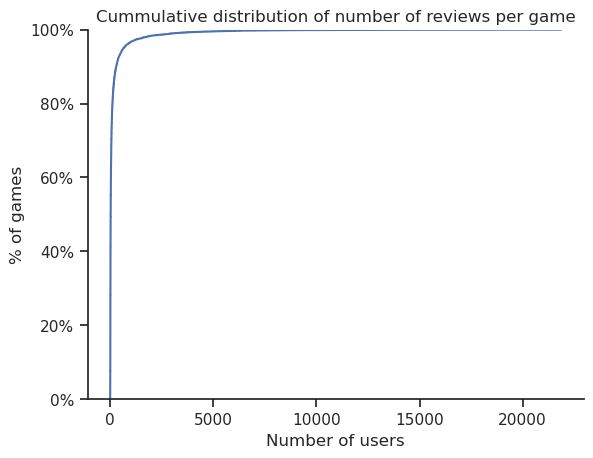

In [13]:
chart = sns.ecdfplot(data=rated_games, x='user')
chart.set(xlabel="Number of users",
       ylabel='% of games',
       title='Cummulative distribution of number of reviews per game')
chart.yaxis.set_major_formatter(PercentFormatter(1,0))

[Text(0.5, 0, 'Average score'),
 Text(0, 0.5, 'Number of games'),
 Text(0.5, 1.0, 'Distribution of average rating per game')]

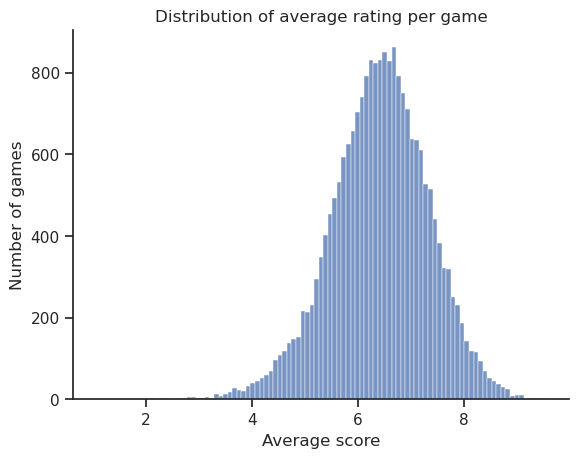

In [14]:
# similar to what we saw in the reviews histogram, most games are rated around 7
# with a larger tail towards the lower scores
ax = sns.histplot(data=games_info, x='average')
ax.set(xlabel="Average score",
       ylabel='Number of games',
       title='Distribution of average rating per game')

Text(0.5, 0.98, 'Number of games by average score')

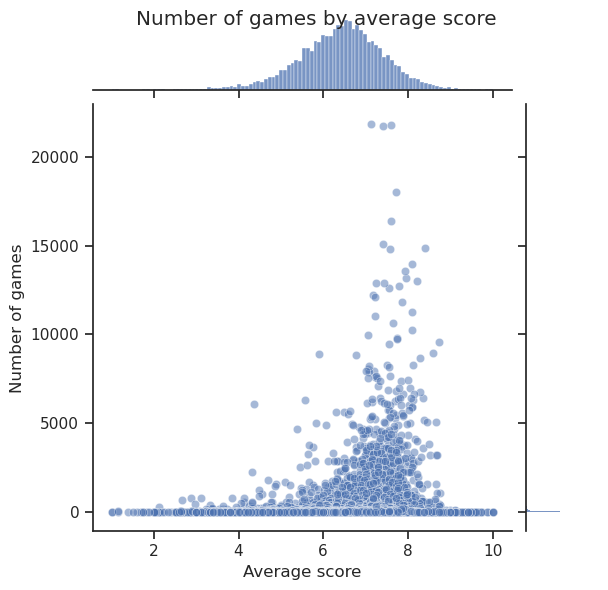

In [15]:
# a game that has more users who rated it, is more likely to have a higher score
# which make sense because people will tend to play and rate more likeable games
chart = sns.jointplot(data=rated_games, x='rating',y='user', alpha=0.5)
chart.set_axis_labels(xlabel="Average score", ylabel='Number of games')
chart.fig.suptitle('Number of games by average score')

## Recommender Model

In [16]:
# for the sake of the example, the model is only going to use the top X games
# in terms of the number of raters
rated_games = rated_games.sort_values(by='user', ascending=False)
rated_games = rated_games.head(TOP_GAMES)

In [17]:
# after filtering, we are left with about 50% of the original size
sample_reviews = reviews[reviews['id'].isin(rated_games['id'])]
len(sample_reviews)

2396877

In [18]:
games_matrix = sample_reviews.pivot_table(index='user',columns='id',values='rating')
games_matrix.head(2)

id,1,3,5,10,11,12,13,15,18,28,...,300531,306735,308765,312484,314040,316554,317985,318977,328871,329465
user,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# lets pick a game a see the recommendations for it
# if you havn't picked a game in the constants, we would pick a random one
if EXAMPLE_GAME is None:
    random_game = rated_games.sample(1).to_dict('records')[0]
    game_id = random_game['id']
else:
    game_id = EXAMPLE_GAME

In [20]:
single_game_corr = games_matrix.corrwith(games_matrix[game_id])
single_game_corr = pd.DataFrame(single_game_corr, columns=["correlation"])
single_game_corr = single_game_corr.dropna().sort_values(by="correlation",ascending=False)
recommender_results = single_game_corr.join(games_info.set_index("id")).reset_index()

In [21]:
# lets filter out the list to find the best recommendations

# filter the game that we used
recommender_results = recommender_results[recommender_results['id']!=game_id]
# filter based on correlation
recommender_results = recommender_results[recommender_results['correlation']>=CORRELATION_THRESHOLD]
for filter_type, filter_value in CATEGORY_FILTER.items():
    if filter_value is not None:
        recommender_results = recommender_results[recommender_results[filter_type].str.contains(filter_value)]
for filter_type, filter_value in NUMERIC_FILTER.items():
    if filter_value is not None:
        if filter_value['measure'] == "above":
            recommender_results = recommender_results[recommender_results[filter_type]>=filter_value['threshold']]
        else:
            recommender_results = recommender_results[recommender_results[filter_type]<=filter_value['threshold']]
# see the top 5 results
recommender_results.head()

,id,correlation,primary,yearpublished,minplayers,maxplayers,playingtime,boardgamecategory,boardgamemechanic,boardgamefamily,boardgamedesigner,boardgamepublisher,usersrated,average,Board Game Rank,numcomments,averageweight
2,22825,0.855067,Tide of Iron,2007,2.0,4.0,120.0,"['Miniatures', 'Wargame', 'World War II']","['Action Points', 'Dice Rolling', 'Hand Manage...","['Admin: Better Description Needed!', 'Game: T...","['John Goodenough', 'Corey Konieczka', 'Christ...","['Fantasy Flight Games', 'Edge Entertainment',...",3776,7.20387,905.0,1192,3.4579
3,12902,0.814896,Carcassonne: The City,2004,2.0,4.0,45.0,"['City Building', 'Medieval']","['Area Majority / Influence', 'Tile Placement']","['Cities: Carcassonne (France)', 'Game: Carcas...",['Klaus-Jürgen Wrede'],"['Hans im Glück', '999 Games', 'Ísöld ehf.', '...",4286,7.20872,737.0,1305,2.2644
4,42776,0.761469,Gears of War: The Board Game,2011,1.0,4.0,180.0,"['Fighting', 'Miniatures', 'Science Fiction', ...","['Area Movement', 'Campaign / Battle Card Driv...","['Category: Dungeon Crawler', 'Components: Mul...",['Corey Konieczka'],"['Fantasy Flight Games', 'Edge Entertainment',...",4828,7.46270,522.0,1180,2.8844
5,298047,0.749473,Marvel United,2020,1.0,4.0,40.0,"['Card Game', 'Comic Book / Strip', 'Fighting']","['Cooperative Game', 'Hand Management', 'Modul...","['Admin: Better Description Needed!', 'Comic B...","['Andrea Chiarvesio', 'Eric M. Lang']","['CMON Global Limited', 'Spin Master Ltd.', 'A...",4306,7.68042,409.0,871,1.8271
6,139976,0.712134,Cthulhu Wars,2015,2.0,4.0,120.0,"['Fantasy', 'Fighting', 'Horror', 'Miniatures']","['Action Points', 'Area Majority / Influence',...","['Crowdfunding: Kickstarter', 'Game: Cthulhu W...","['Sandy Petersen', 'Lincoln Petersen']","['Petersen Games', 'Arclight', 'BoardM Factory...",4899,7.90088,269.0,1067,3.1457


In [22]:
# so if you liked this game
games_info[games_info['id']==game_id]

,id,primary,yearpublished,minplayers,maxplayers,playingtime,boardgamecategory,boardgamemechanic,boardgamefamily,boardgamedesigner,boardgamepublisher,usersrated,average,Board Game Rank,numcomments,averageweight
339,183840,Oh My Goods!,2015,2.0,4.0,30.0,"['Card Game', 'Economic', 'Medieval']","['Action Queue', 'Hand Management', 'Push Your...","['Admin: Better Description Needed!', 'Compone...",['Alexander Pfister'],"['Lookout Games', 'Österreichisches Spiele Mus...",10434,7.00019,662.0,1802,2.2917


In [23]:
# then maybe you should try out 
recommender_results.head(1)

,id,correlation,primary,yearpublished,minplayers,maxplayers,playingtime,boardgamecategory,boardgamemechanic,boardgamefamily,boardgamedesigner,boardgamepublisher,usersrated,average,Board Game Rank,numcomments,averageweight
2,22825,0.855067,Tide of Iron,2007,2.0,4.0,120.0,"['Miniatures', 'Wargame', 'World War II']","['Action Points', 'Dice Rolling', 'Hand Manage...","['Admin: Better Description Needed!', 'Game: T...","['John Goodenough', 'Corey Konieczka', 'Christ...","['Fantasy Flight Games', 'Edge Entertainment',...",3776,7.20387,905.0,1192,3.4579
